In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install opencv-python
!pip install numpy
!pip install matplotlib
!pip install scikit-fmm
!pip install cairosvg
!pip install svgwrite

In [3]:
!unzip /content/drive/MyDrive/problems.zip

Archive:  /content/drive/MyDrive/problems.zip
   creating: problems/
  inflating: problems/occlusion2.csv  
  inflating: problems/occlusion1.csv  
  inflating: problems/.DS_Store      
  inflating: __MACOSX/problems/._.DS_Store  
  inflating: problems/occlusion1_sol.svg  
  inflating: problems/frag01_sol.svg  
  inflating: problems/frag1.csv      
  inflating: problems/frag0.csv      
  inflating: problems/frag2.csv      
  inflating: problems/isolated.csv   
  inflating: problems/occlusion2_sol.svg  
  inflating: __MACOSX/problems/._occlusion2_sol.svg  
  inflating: problems/frag2_sol.csv  
  inflating: problems/isolated_sol.csv  
  inflating: problems/occlusion1_sol.csv  
  inflating: problems/occlusion1_sol_rec.png  
  inflating: problems/occlusion2_sol_rec.svg  
  inflating: problems/occlusion2_rec.svg  
  inflating: problems/frag01_sol.csv  
  inflating: problems/occlusion2.svg  
  inflating: problems/occlusion1_rec.png  
  inflating: problems/occlusion1.svg  
  inflating: __MACOS

In [ ]:
import cairosvg
import os

def convert_svg_to_jpg(svg_path, output_folder):
    filename = os.path.splitext(os.path.basename(svg_path))[0]
    output_path = os.path.join(output_folder, filename + '.jpg')

    cairosvg.svg2png(url=svg_path, write_to=output_path)
    print(f"Converted {svg_path} to {output_path}")

In [ ]:
svg_file = "/content/problems/occlusion1.svg"
output_dir = "/content/problems/"

convert_svg_to_jpg(svg_file, output_dir)

Converted /content/problems/occlusion1.svg to /content/problems/occlusion1.jpg


In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
def preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours

In [6]:
def extract_features(contours):
    shapes = []
    for contour in contours:
        epsilon = 0.01 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        x, y, w, h = cv2.boundingRect(approx)
        aspect_ratio = float(w) / h
        area = cv2.contourArea(contour)
        perimeter = cv2.arcLength(contour, True)
        if len(approx) == 2:
            shape = "Line"
        elif len(approx) == 3:
            shape = "Triangle"
        elif len(approx) == 4:
            shape = "Rectangle" if 0.95 <= aspect_ratio <= 1.05 else "Quadrilateral"
            if shape == "Rectangle":
                is_rounded = False
                for i in range(len(approx)):
                    p1 = approx[i][0]
                    p2 = approx[(i + 1) % len(approx)][0]
                    corner_angle = np.degrees(np.arctan2(p2[1] - p1[1], p2[0] - p1[0]))
                    if 75 < corner_angle < 105 or -105 < corner_angle < -75:
                        is_rounded = True
                        break
                if is_rounded:
                    shape = "Rounded Rectangle"
        elif len(approx) > 10:
            (x, y), (MA, ma), angle = cv2.fitEllipse(approx)
            shape = "Circle" if 0.95 <= MA / ma <= 1.05 else "Ellipse"
        else:
            shape = "Polygon"
        shapes.append((shape, approx, area, perimeter))
    return shapes

In [7]:
def classify_shapes(shapes):
    classified_shapes = []
    for shape, approx, area, perimeter in shapes:
        if shape == "Line":
            classified_shapes.append(("Line", approx))
        elif shape == "Triangle":
            classified_shapes.append(("Triangle", approx))
        elif shape == "Rectangle":
            classified_shapes.append(("Rectangle", approx))
        elif shape == "Rounded Rectangle":
            classified_shapes.append(("Rounded Rectangle", approx))
        elif shape == "Circle":
            classified_shapes.append(("Circle", approx))
        elif shape == "Ellipse":
            classified_shapes.append(("Ellipse", approx))
        elif shape == "Polygon":
            if len(approx) == 5:
                classified_shapes.append(("Pentagon", approx))
            elif len(approx) == 6:
                classified_shapes.append(("Hexagon", approx))
            elif len(approx) == 7:
                classified_shapes.append(("Heptagon", approx))
            elif len(approx) == 8:
                classified_shapes.append(("Octagon", approx))
            else:
                classified_shapes.append(("Polygon", approx))
    return classified_shapes

In [8]:
def visualize_shapes(image_path, classified_shapes):
    image = cv2.imread(image_path)
    for shape, approx in classified_shapes:
        cv2.drawContours(image, [approx], 0, (0, 255, 0), 2)
        x, y = approx[0][0]
        cv2.putText(image, shape, (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

In [9]:
def read_csv_(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

In [10]:
def plot(paths_XYs, title, ax):
    colours = ['red', 'green', 'blue']
    for i, XYs in enumerate(paths_XYs):
        c = colours[i % len(colours)]
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], c=c, linewidth=2)
    ax.set_aspect('equal')
    ax.set_title(title)

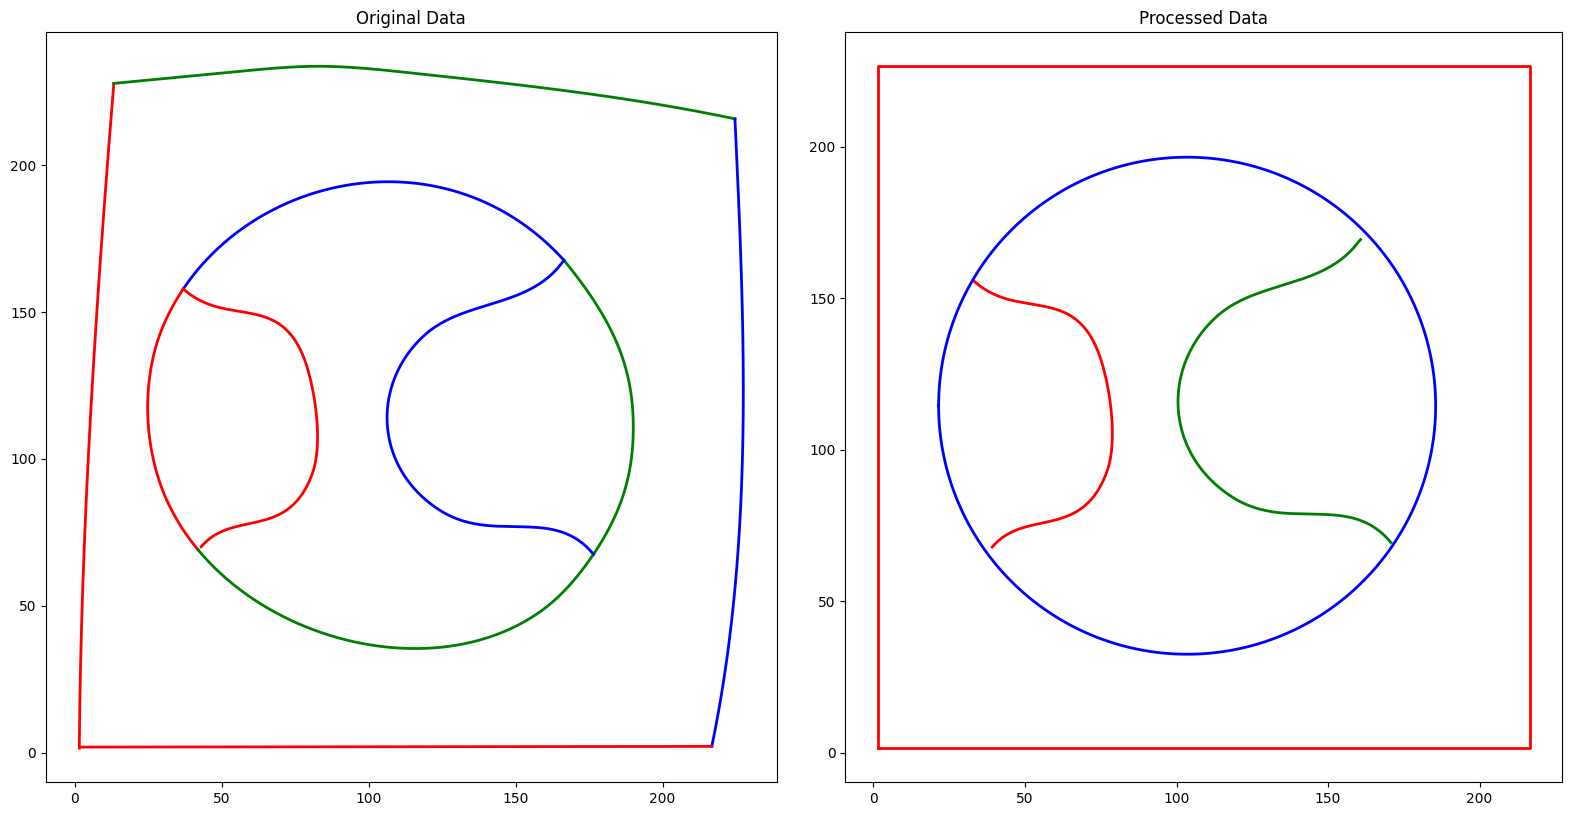

In [11]:
csv_path1 = "/content/problems/frag0.csv"
csv_path2 = "/content/problems/frag01_sol.csv"

output_data1 = read_csv_(csv_path1)
output_data2 = read_csv_(csv_path2)

# Plot side by side
fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(16, 8))
plot(output_data1, 'Original Data', axs[0])
plot(output_data2, 'Processed Data', axs[1])
plt.show()

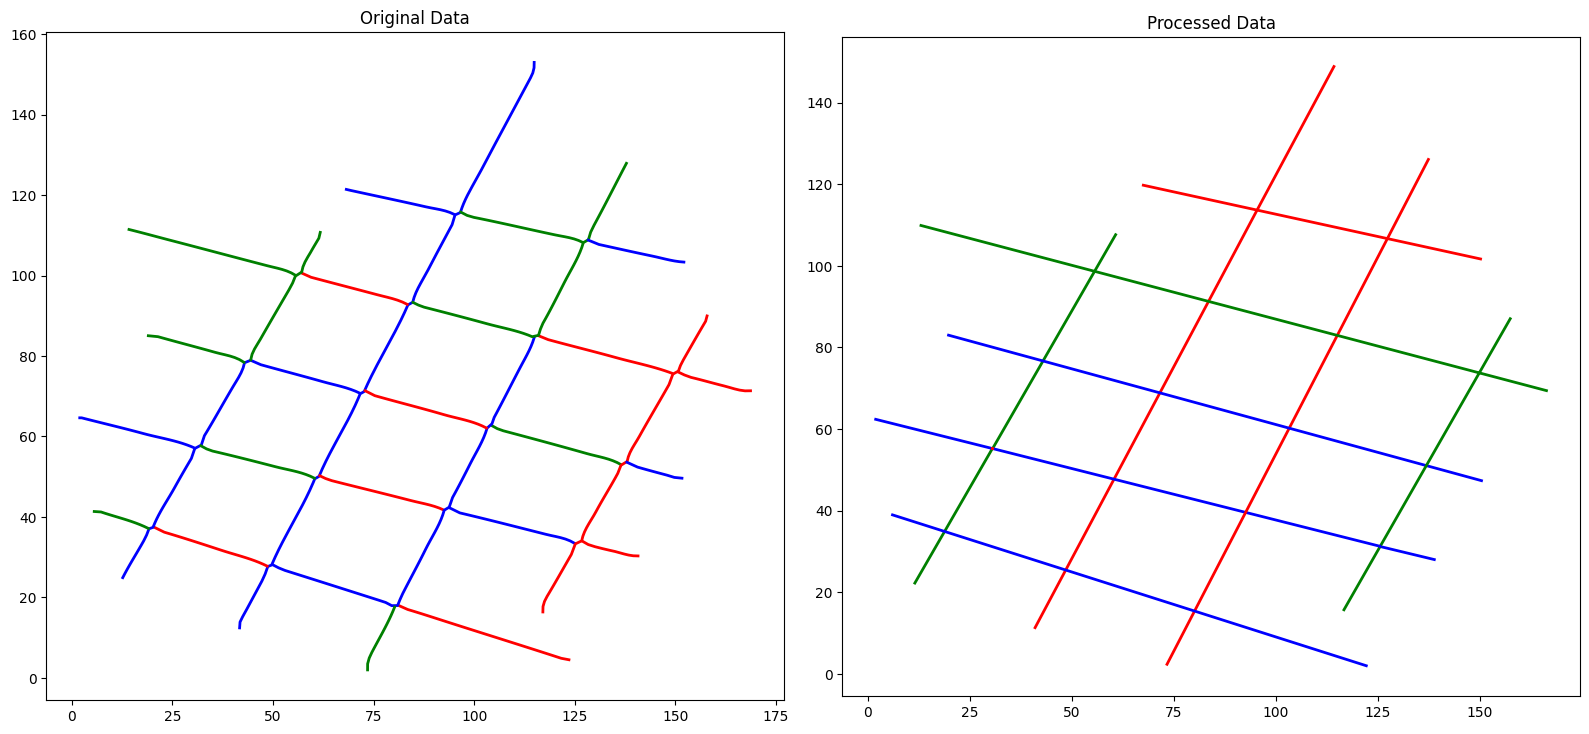

In [12]:
csv_path1 = "/content/problems/frag2.csv"
csv_path2 = "/content/problems/frag2_sol.csv"

output_data1 = read_csv_(csv_path1)
output_data2 = read_csv_(csv_path2)

# Plot side by side
fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(16, 8))
plot(output_data1, 'Original Data', axs[0])
plot(output_data2, 'Processed Data', axs[1])
plt.show()

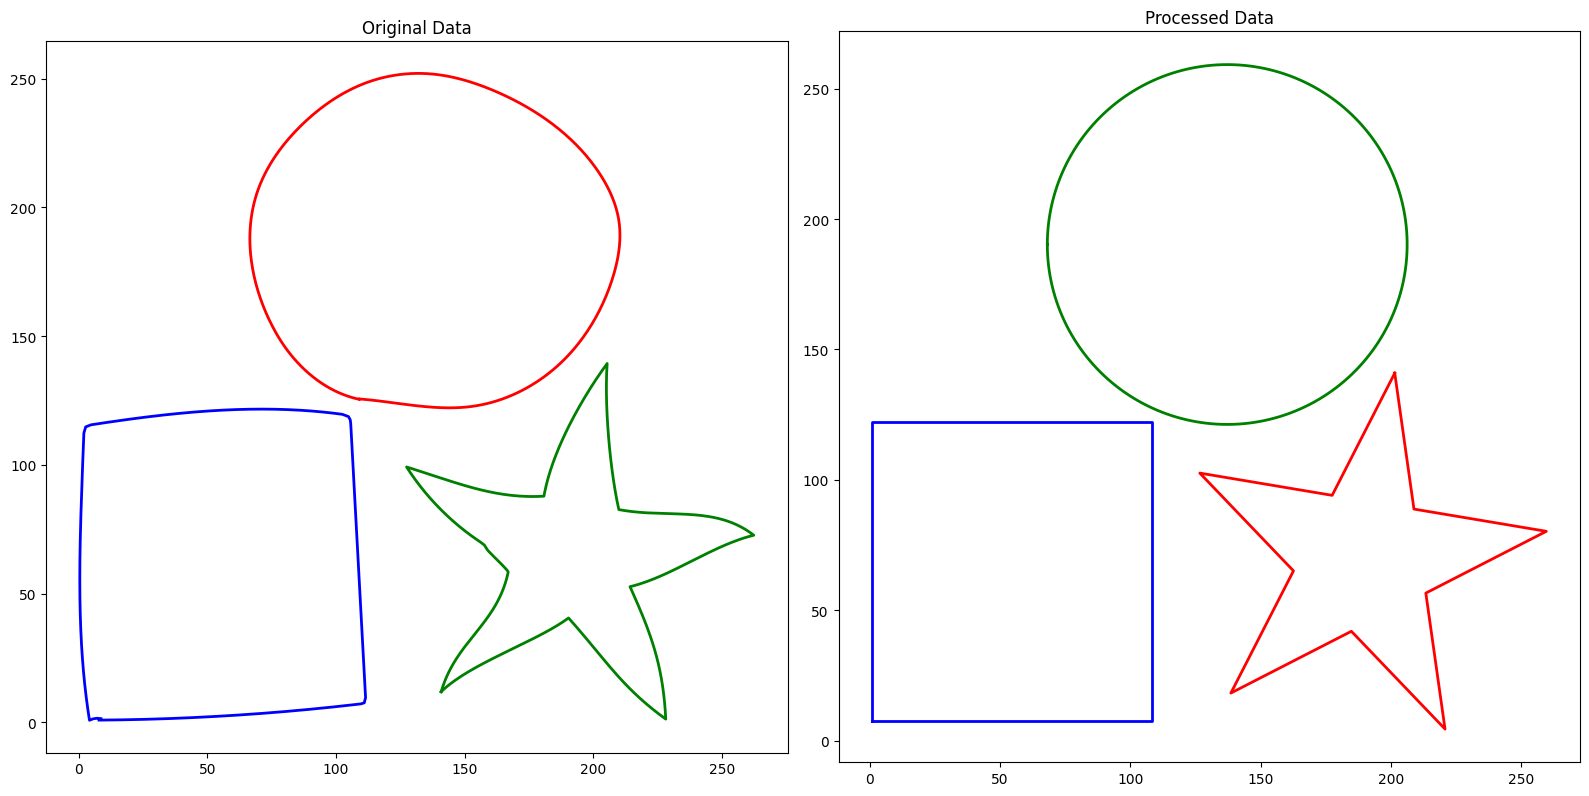

In [13]:
csv_path1 = "/content/problems/isolated.csv"
csv_path2 = "/content/problems/isolated_sol.csv"

output_data1 = read_csv_(csv_path1)
output_data2 = read_csv_(csv_path2)

# Plot side by side
fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(16, 8))
plot(output_data1, 'Original Data', axs[0])
plot(output_data2, 'Processed Data', axs[1])
plt.show()

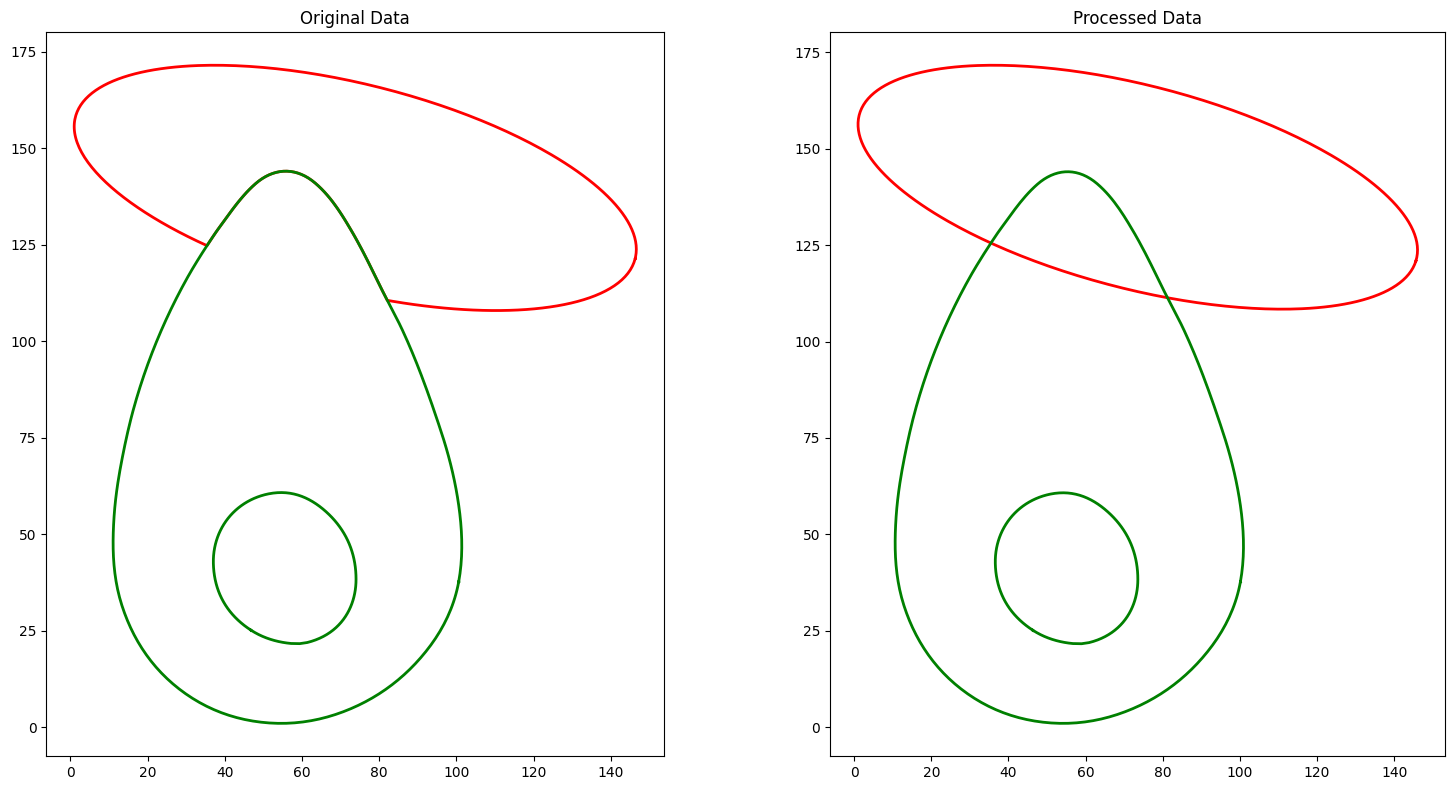

In [14]:
csv_path1 = "/content/problems/occlusion1.csv"
csv_path2 = "/content/problems/occlusion1_sol.csv"

output_data1 = read_csv_(csv_path1)
output_data2 = read_csv_(csv_path2)

# Plot side by side
fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(16, 8))
plot(output_data1, 'Original Data', axs[0])
plot(output_data2, 'Processed Data', axs[1])
plt.show()

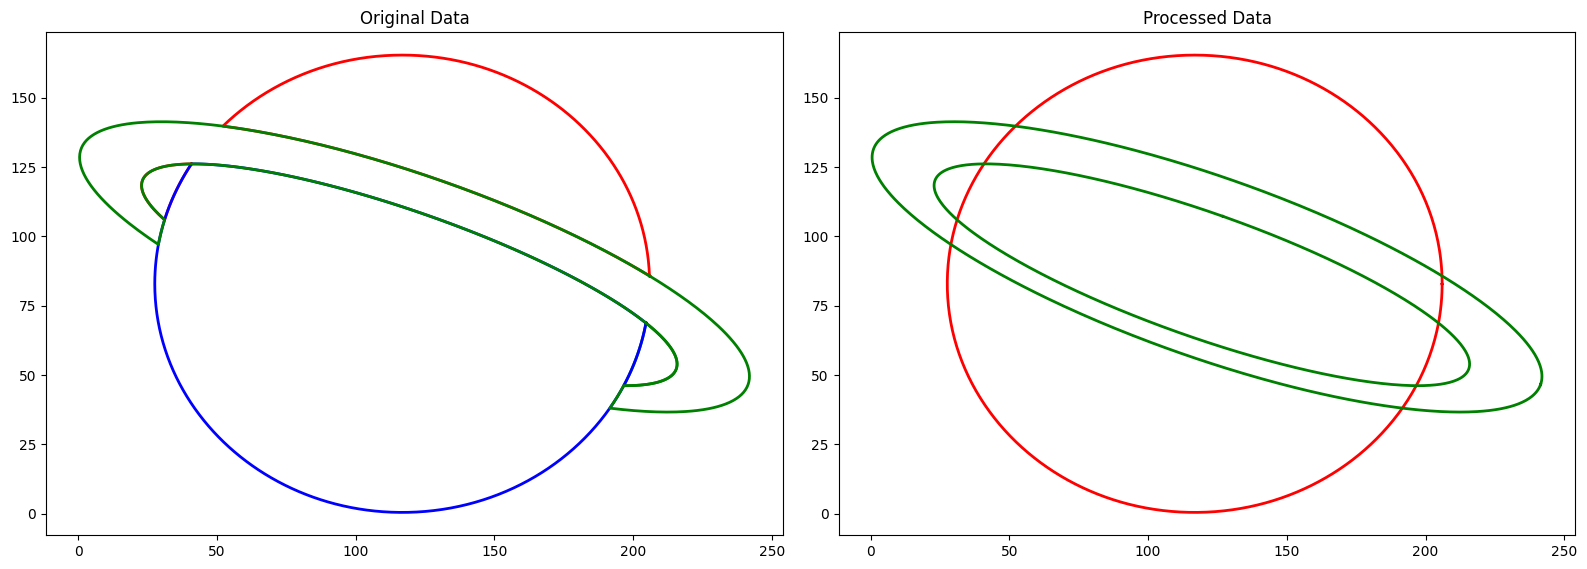

In [15]:
csv_path1 = "/content/problems/occlusion2.csv"
csv_path2 = "/content/problems/occlusion2_sol.csv"

output_data1 = read_csv_(csv_path1)
output_data2 = read_csv_(csv_path2)

# Plot side by side
fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(16, 8))
plot(output_data1, 'Original Data', axs[0])
plot(output_data2, 'Processed Data', axs[1])
plt.show()